## import library python

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

## iterate through the folders to create a dataframe of the form filepaths labels

In [3]:
sdir=r'Coffee Leaves'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                            filepaths        labels
0    Coffee Leaves\embun_jelaga\1.JPG  embun_jelaga
1   Coffee Leaves\embun_jelaga\10.JPG  embun_jelaga
2  Coffee Leaves\embun_jelaga\100.JPG  embun_jelaga
3  Coffee Leaves\embun_jelaga\101.JPG  embun_jelaga
4  Coffee Leaves\embun_jelaga\102.JPG  embun_jelaga
embun_jelaga              350
karat_daun                350
sehat                     350
tungau_laba_laba_merah    350
Name: labels, dtype: int64


## split df into train_df, test_df and valid_df

In [4]:
train_split =0.7
test_split =0.15
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  979   test_df length:  210   valid_df length:  211


## create train, test, valid generators

In [5]:
height=128
width=128
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(
    rescale=1./255
)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(
    rescale=1./255
)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  70   test steps:  3
Found 979 validated image filenames belonging to 4 classes.
Found 211 validated image filenames belonging to 4 classes.
Found 210 validated image filenames belonging to 4 classes.
['embun_jelaga', 'karat_daun', 'sehat', 'tungau_laba_laba_merah']


## create function to show some image examples

In [6]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

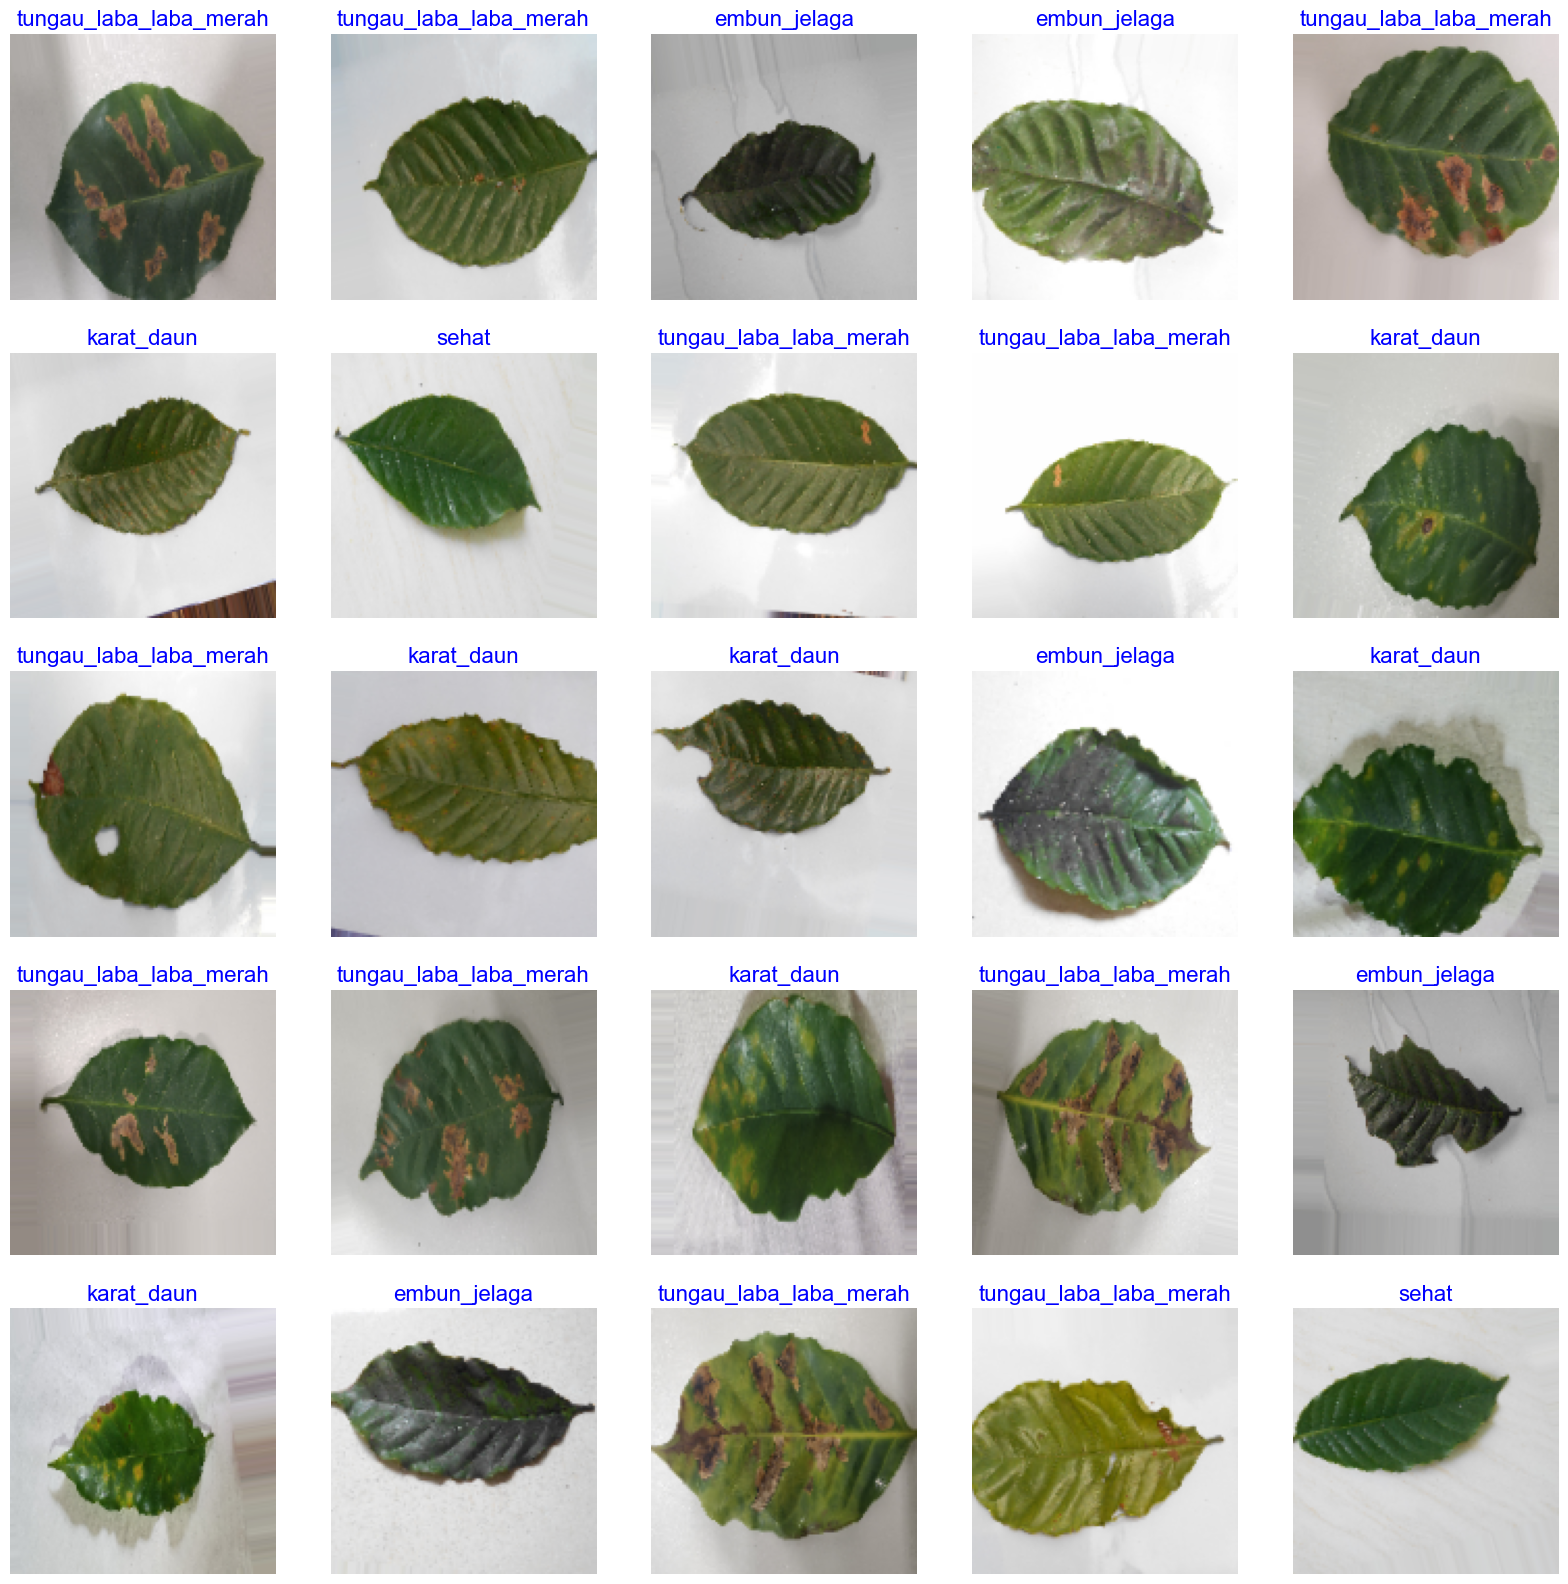

In [7]:
show_image_samples(train_gen)

## create the model

In [8]:
model_name='Alexnet'

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides= 4, padding= 'valid', activation= 'relu', input_shape= (128, 128, 3), kernel_initializer= 'he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', data_format= None),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',kernel_initializer= 'he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', data_format= None),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',kernel_initializer= 'he_normal'),    
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',kernel_initializer= 'he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', data_format= None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(class_count, activation= 'softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          9

In [10]:
epochs = 100                                                  

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/100


16/16 [==============================] - 181s 11s/step - loss: 1.3990 - accuracy: 0.2441 - val_loss: 1.3891 - val_accuracy: 0.2654
Epoch 2/100
16/16 [==============================] - 209s 13s/step - loss: 1.3812 - accuracy: 0.2503 - val_loss: 1.3771 - val_accuracy: 0.2654
Epoch 3/100
16/16 [==============================] - 211s 13s/step - loss: 1.3496 - accuracy: 0.3596 - val_loss: 1.2343 - val_accuracy: 0.5308
Epoch 4/100
16/16 [==============================] - 214s 13s/step - loss: 1.1597 - accuracy: 0.4576 - val_loss: 0.9351 - val_accuracy: 0.5877
Epoch 5/100
16/16 [==============================] - 214s 13s/step - loss: 0.8621 - accuracy: 0.6343 - val_loss: 0.7110 - val_accuracy: 0.6872
Epoch 6/100
16/16 [==============================] - 213s 13s/step - loss: 1.0410 - accuracy: 0.5802 - val_loss: 1.1795 - val_accuracy: 0.5355
Epoch 7/100
16/16 [==============================] - 214s 13s/step - loss: 0.8970 - accuracy: 0.6292 - val_loss: 0.7180 - val_accuracy: 0.76

## define function to print text in RGB foreground and background colors

In [11]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

## define function to plot the training data

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

## define function to generate the confusion matrix and classification report

In [13]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

## evaluate model on the test set then save the model

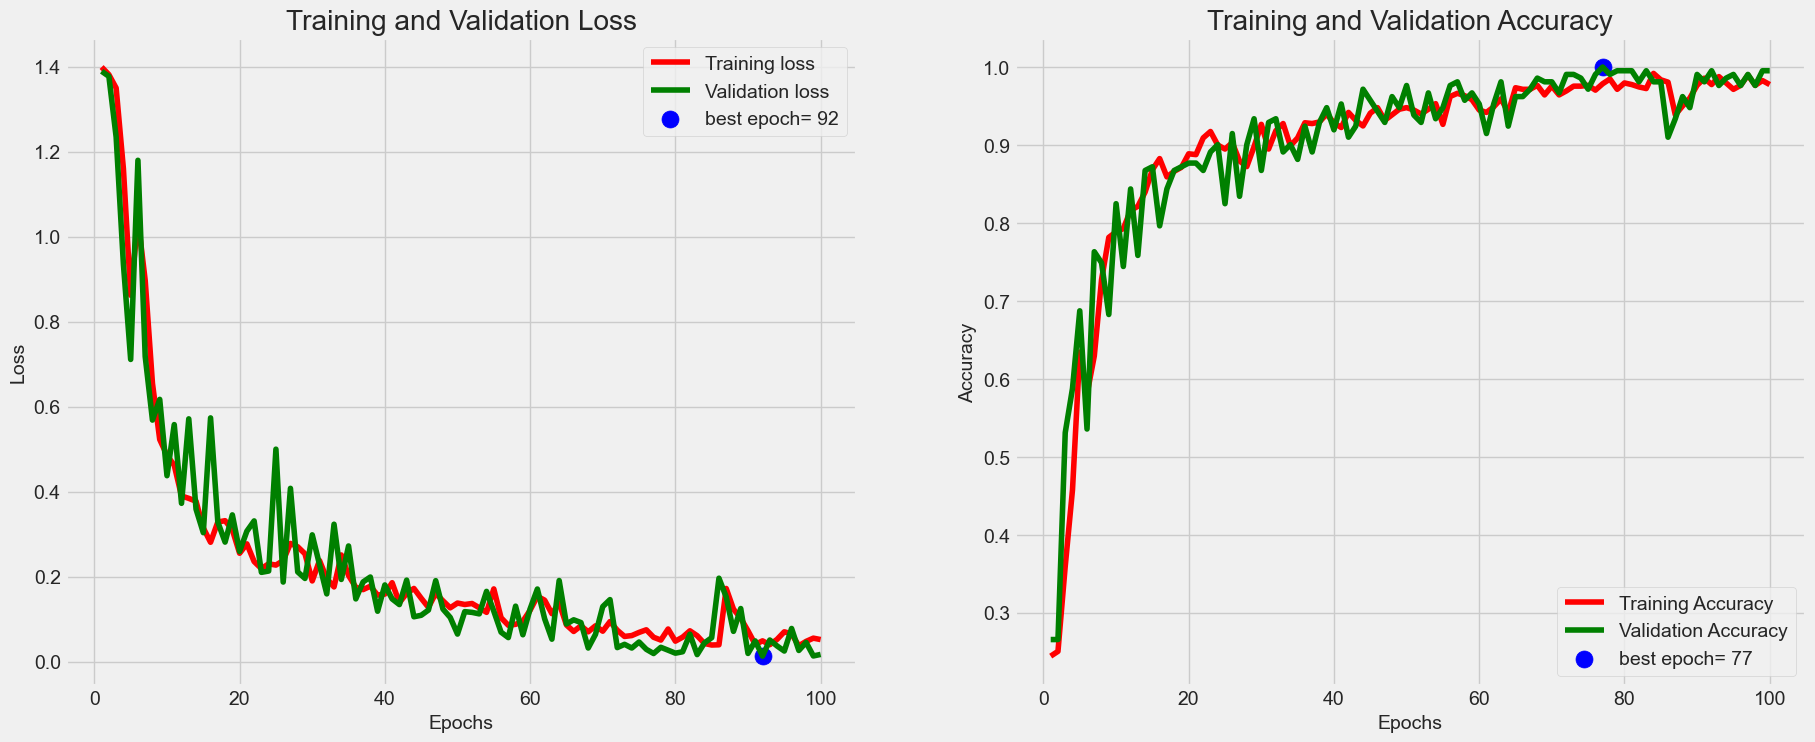

3/3 [==============================] - 35s 12s/step - loss: 0.0139 - accuracy: 0.9952
accuracy on the test set is 99.52 %



c:\Users\Nadia Ashari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

## make predictions on test set and generate confusion matrix and classification report

3/3 [==============================] - 36s 12s/step


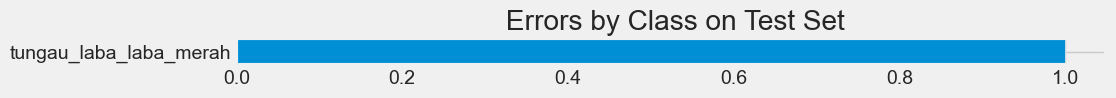

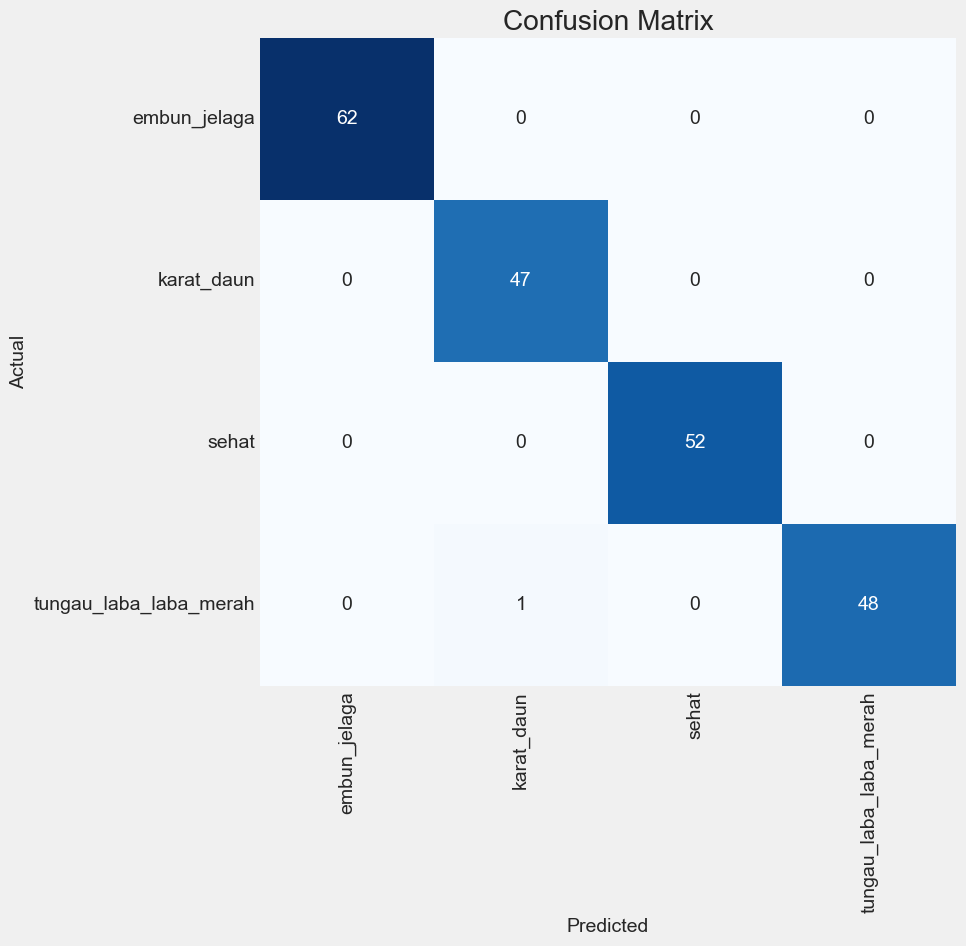

Classification Report:
----------------------
                         precision    recall  f1-score   support

          embun_jelaga       1.00      1.00      1.00        62
            karat_daun       0.98      1.00      0.99        47
                 sehat       1.00      1.00      1.00        52
tungau_laba_laba_merah       1.00      0.98      0.99        49

              accuracy                           1.00       210
             macro avg       0.99      0.99      0.99       210
          weighted avg       1.00      1.00      1.00       210



In [15]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )